# Amortissement

In [21]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [22]:
def load(filename: str):
    return pd.read_csv(filename)

In [23]:
acier_doux = load('../data/acier_doux_temp.csv')

## Plot this shit

## TODO: utiliser la formule pour Q_inv et remplacer Q_inv_auto par Q_inv_err (qui contient les uncertainties)

525.81


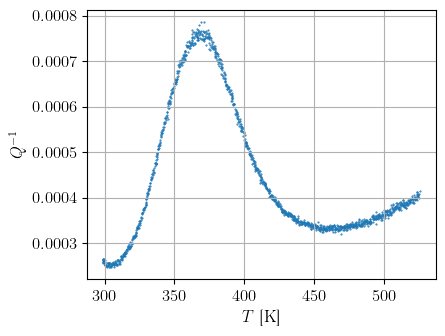

In [24]:
Q_inv_auto = acier_doux['fit_Q_1']

Q_inv = Q_inv_auto  # TODO: a changer avec le Q_inv_err

T = acier_doux['T[C]'] + 273.15  # K
print(T[len(T)-1])
plt.scatter(T, nom_vals(Q_inv), 1, marker='.')
plt.xlabel(r'$T$ [\si{\kelvin}]')
plt.ylabel(r'$Q^{-1}$')
plt.grid()

In [25]:
from matplotlib.path import Path
from matplotlib.widgets import LassoSelector
class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

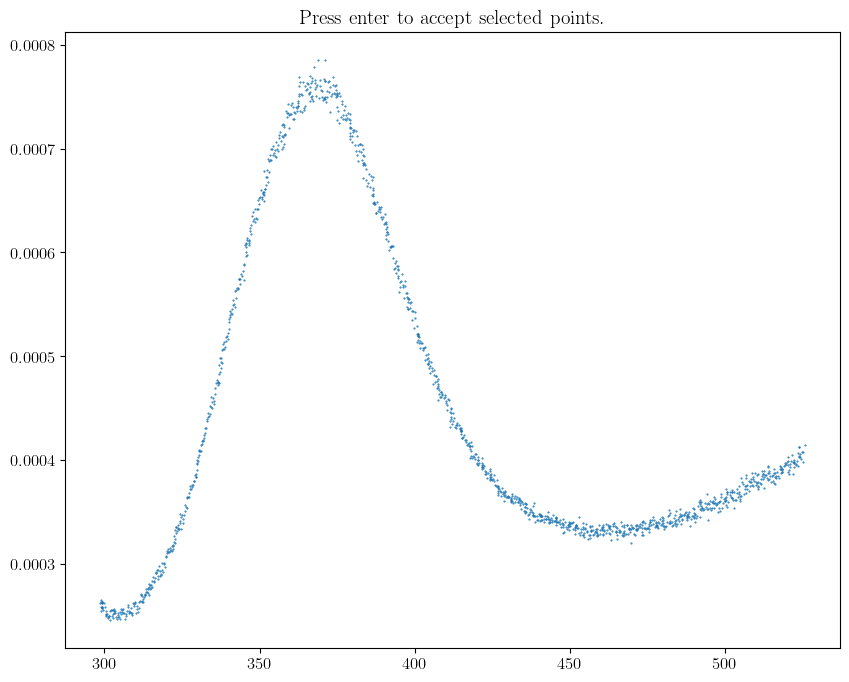

Fit: ((1.0±0.1)×10⁻⁹)x^2 + ((-3±1)×10⁻⁷)x + ((2.5±0.2)×10⁻⁴)


In [28]:
%matplotlib widget
plt.close()
fig, ax = plt.subplots(figsize=(10, 8))
datas = (i for i in [acier_doux])
curr = None
deg = 2  # degré du fit
fit_dict = {}

def plot(data) -> SelectFromCollection:
    pts = ax.scatter(data[0], data[1], marker=".", s=1, picker=5)
    selector = SelectFromCollection(ax, pts)
    return selector

selector = None
def load_next():
    global selector, curr
    try:
        curr = 'acier_doux'
    except StopIteration:
        plt.close()
        return
    data = [T, Q_inv]
    selector = plot(data)

def accept(event):
    global selector, curr
    if event.key == "enter":
        selected = selector.xys[selector.ind]
        coefs, cov = np.polyfit(selected[:,0], selected[:,1], deg, cov=True)
        coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))
        if deg == 1:
            print("Fit: ({:.1ueP})x + ({:.1ueP})".format(*coefs_err))
        elif deg == 2:
            print("Fit: ({:.1ueP})x^2 + ({:.1ueP})x + ({:.1ueP})".format(*coefs_err))
        fit_dict[curr] = coefs_err
        # Show fit
        fit = np.poly1d(coefs)
        x = np.linspace(np.min(selected[:,0]), np.max(selected[:,0]), 50)
        ax.plot(x, fit(x), color="red", linewidth=1)
        # selector.disconnect()
        # ax.set_title("")
        fig.canvas.draw()
    if event.key == "escape":
        selector.disconnect()
        # plt.cla()
        fit_func = np.poly1d(nom_vals(fit_dict['acier_doux']))
        plt.scatter(T, nom_vals(Q_inv - fit_func(T)), 1, marker='.')
        plt.xlabel(r'$T$ [\si{\kelvin}]')
        plt.ylabel(r'$Q^{-1}$')
        plt.grid()
    

fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points.")
load_next()

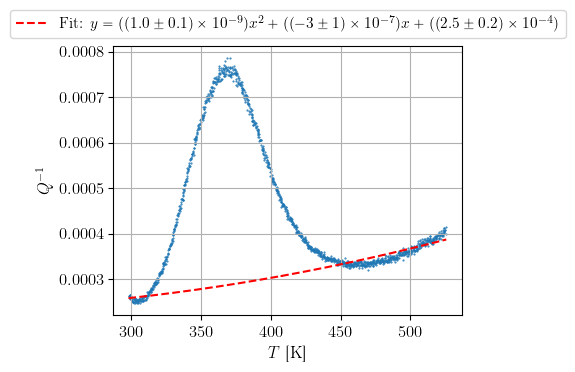

In [29]:
%matplotlib inline
plt.close()

fit_func = np.poly1d(nom_vals(fit_dict['acier_doux']))
plt.scatter(T, nom_vals(Q_inv), 1, marker='.')

label = "Fit: $y = ({:.1ueL})x^2 + ({:.1ueL})x + ({:.1ueL})$".format(*fit_dict['acier_doux'])
plt.plot(T, fit_func(T), 'r--', label=label)
plt.xlabel(r'$T$ [\si{\kelvin}]')
plt.ylabel(r'$Q^{-1}$')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
plt.grid()

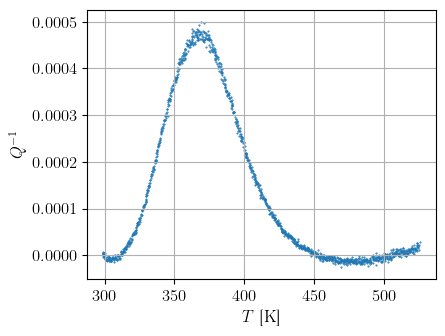

In [30]:
fit_func = np.poly1d(nom_vals(fit_dict['acier_doux']))
Q_inv_corrected = Q_inv - fit_func(T)
plt.scatter(T, nom_vals(Q_inv_corrected), 1, marker='.')
plt.xlabel(r'$T$ [\si{\kelvin}]')
plt.ylabel(r'$Q^{-1}$')
plt.grid()

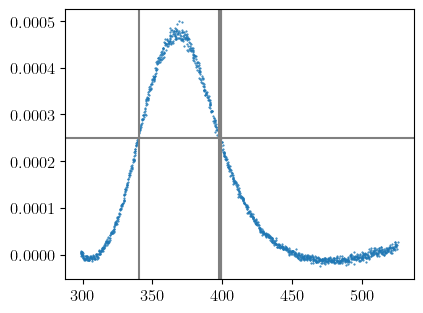

In [31]:
# Vars
# Delta = ... # LE PARAM QU'ON CHERCHE A FIT? 2 * hauteur max de Q^-1
max_idx = np.argmax(Q_inv_corrected)

# https://stackoverflow.com/questions/2652368/how-to-detect-a-sign-change-for-elements-in-a-numpy-array
Delta_2_max = Q_inv_corrected[max_idx]
offset_Q_inv = Q_inv_corrected - Delta_2_max / 2
mi_hauteur_idx = np.where(np.diff(np.sign(offset_Q_inv)) != 0)[0] + 1
# Visualise this awful shitty ass code
plt.scatter(T, Q_inv_corrected, 1, marker='.')
plt.axhline(Delta_2_max / 2)
for i in mi_hauteur_idx:
    plt.axvline(T[i])


In [32]:
T_4s = T[mi_hauteur_idx]


T_4_mins = T_4s[T_4s <= T_4s.min() +10]
T_min = T_4_mins.mean()
T_min_err = T_4_mins.max() - T_4_mins.min()
T_1 = ufloat(T_min, T_min_err)

T_4_maxs = T_4s[T_4s >= T_4s.max() -10]
T_max = T_4_maxs.mean()
T_max_err = T_4_maxs.max() - T_4_maxs.min()
T_2 = ufloat(T_max, T_max_err)


T_p = T[max_idx]   # argmax(Q_inv)

T_ps = T[Q_inv_corrected >= Q_inv_corrected[max_idx] -1e-5]
T_p_temp = T_ps.mean()
T_p_err = T_ps.max() - T_ps.min()
T_p = ufloat(T_p_temp, T_p_err)



H = 2.634 * k_boltzmann / (1/T_1 - 1/T_2)

print(mi_hauteur_idx)
print(Delta_2_max)
print(f"Tp = {T_p:.1ueP}")
print(f"T1 = {T_1:.1ueP}")
print(f"T2 = {T_2:.1ueP}")
print(f"H = {H:.1ueP}")


[248 591 594 596 597 598]
0.0004990020945753253
Tp = (3.69±0.03)×10²
T1 = (3.4±0)×10²
T2 = (3.99±0.01)×10²
H = (8.4±0.2)×10⁻²⁰


## Now fit it

In [33]:
# def Q_inv_func(T, Delta, H_fit):
#     return Delta / (2 * np.cosh(H_fit / k_boltzmann * (1/T_p - 1/T)))

def Q_inv_func(T, Delta):
    return Delta / (2 * np.cosh(nom_vals(H) / k_boltzmann * (1/nom_vals(T_p) - 1/T)))


Delta = (9.43±0.04)×10⁻⁴
Fit: $y = \frac{\left(9.43 \pm 0.04\right) \times 10^{-4}}{2 \cosh (\left(6.1 \pm 0.1\right) \times 10^{3} (369.1+/-3.5^{-1} - x^{-1}))}$


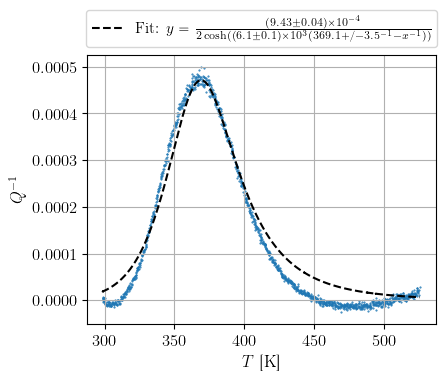

In [34]:
subset = np.arange(0, len(T))
T_subset = T[subset]
Q_inv_corrected_subset = Q_inv_corrected[subset]
coefs, cov = sc.optimize.curve_fit(Q_inv_func, T_subset, Q_inv_corrected_subset, bounds=([-np.inf], [np.inf]))
coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))
print(f"Delta = {coefs_err[0]:.1ueP}")
# print(f"H_fit = {coefs_err[1]:.1ueP}")

Delta_fit = coefs_err[0]
Delta_max = 2*Delta_2_max

label = r"Fit: $y = \frac{{{:.1ueL}}}{{2 \cosh ({:.1ueL} ({:.1f}^{{-1}} - x^{{-1}}))}}$".format(coefs_err[0], H/k_boltzmann, T_p)
print(label)
plt.plot(T_subset, Q_inv_func(T_subset, *coefs), 'k--', label=label)
plt.scatter(T_subset, nom_vals(Q_inv_corrected_subset), 1, marker='.')
plt.xlabel(r'$T$ [\si{\kelvin}]')
plt.ylabel(r'$Q^{-1}$')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
plt.grid()

## Calcul concentration interstitiel

In [35]:
print(f"Delta fit = {Delta_fit:.1ueP}")
print(f"Delta max = {Delta_max:.3e}")

Delta fit = (9.43±0.04)×10⁻⁴
Delta max = 9.980e-04


In [36]:
E_doux = ufloat(180, 7) * 1e9
Ju = 1 / E_doux

c0 = (9 * Delta_fit * Ju * k_boltzmann * T_p) / (2 * v_0 * Delta_lambda**2)

print(f"concentration interstitiels c0 = {c0:.1ueP}")

concentration interstitiels c0 = (1.02±0.04)×10⁻⁴
